In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
import os

In [3]:
%cd /content/curvetopia-files/problems

/content/curvetopia-files/problems


In [4]:
folder_path = '.'
csv_files = [os.path.join(folder_path, f) for f in os.listdir(folder_path) if f.endswith('.csv')]

# Print the file paths
for file_path in csv_files:
    print(file_path)

./occlusion2_sol.csv
./occlusion2.csv
./frag2.csv
./isolated.csv
./occlusion1.csv
./frag1.csv
./frag0.csv
./frag2_sol.csv
./frag01_sol.csv
./occlusion1_sol.csv
./isolated_sol.csv


In [5]:
def group_segments_by_curve(csv_file, tolerance=1e-5):
    
    # Read the CSV file
    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

    # Initialize variables
    segments = []
    for segment_no in df['segment_no'].unique():
        segment_df = df[df['segment_no'] == segment_no]
        for sub_segment in segment_df['sub_segment'].unique():
            sub_segment_df = segment_df[segment_df['sub_segment'] == sub_segment]
            x_start = sub_segment_df['x'].values[0]
            y_start = sub_segment_df['y'].values[0]
            x_end = sub_segment_df['x'].values[-1]
            y_end = sub_segment_df['y'].values[-1]
            start_point = (x_start, y_start)
            end_point = (x_end, y_end)
            segments.append(((segment_no, sub_segment), start_point, end_point))

    # Lists to store curves
    closed_curves = []
    open_curves = []

    # Function to check if two points are approximately equal within tolerance
    def points_match(point1, point2, tol):
        return np.linalg.norm(np.array(point1) - np.array(point2)) < tol

    # Iterate over segments
    for i in range(len(segments)):
        current_segment = segments[i]
        cur_segment_id = current_segment[0] #tuple (segment_no, segment_id)
        cur_start_point = current_segment[1]
        cur_end_point = current_segment[2]

        # Flag to determine if added to an existing curve
        added_to_curve = False

        # Check if current segment matches any open curve
        for curve in open_curves:
            first_segment_id = curve[0]
            last_segment_id = curve[-1]

            first_segment = next(seg for seg in segments if seg[0] == first_segment_id)
            last_segment = next(seg for seg in segments if seg[0] == last_segment_id)

            if points_match(last_segment[2], cur_start_point, tolerance):
                # Add to the existing curve
                curve.append(cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_end_point, tolerance):
                    # Curve is closed
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break
            elif points_match(first_segment[1], cur_end_point, tolerance):
                # Add to the existing curve
                curve.insert(0, cur_segment_id)
                added_to_curve = True
                if points_match(first_segment[1], cur_start_point, tolerance):
                    # Curve is closed
                    closed_curves.append(curve)
                    open_curves.remove(curve)
                break

        # If not added to any existing curve, start a new open curve
        if not added_to_curve:
            if points_match(cur_start_point, cur_end_point, tolerance):
                # Curve is closed
                closed_curves.append([cur_segment_id])
            else:
                open_curves.append([cur_segment_id])

    return segments, closed_curves, open_curves

In [6]:
def extract_all_points_from_curve(curve, csv_file):
    """Extract all points for the segments in the given curve from the CSV file."""
    df = pd.read_csv(csv_file, header=None)
    df.columns = ['segment_no', 'sub_segment', 'x', 'y']

    # Create a set of tuples from the curve list for filtering
    curve_set = set(curve)

    # Filter the DataFrame to include only rows with (segment_no, sub_segment) in the curve
    curve_segments = df[df.apply(lambda row: (row['segment_no'], row['sub_segment']) in curve_set, axis=1)]

    # Extract points
    points = curve_segments[['x', 'y']].values.tolist()
    return points

In [7]:
def remove_coincident_points(points, curve_boundary, tolerance):
    remaining_points = []

    for point in points:
        is_coincident = False
        for boundary_point in curve_boundary:
            if np.linalg.norm(np.array(point) - np.array(boundary_point)) <= tolerance:
                is_coincident = True
                break
        if not is_coincident:
            remaining_points.append(point)

    return np.array(remaining_points)

In [8]:
def read_csv(csv_path):
    np_path_XYs = np.genfromtxt(csv_path, delimiter=',')
    path_XYs = []
    for i in np.unique(np_path_XYs[:, 0]):
        npXYs = np_path_XYs[np_path_XYs[:, 0] == i][:, 1:]
        XYs = []
        for j in np.unique(npXYs[:, 0]):
            XY = npXYs[npXYs[:, 0] == j][:, 1:]
            XYs.append(XY)
        path_XYs.append(XYs)
    return path_XYs

In [9]:
def plot(paths_XYs, title, ax):
    
    colours = ['red', 'green', 'blue', 'yellow', 'purple']
    for i, XYs in enumerate(paths_XYs):
        c = colours[i % len(colours)]
        for XY in XYs:
            ax.scatter(XY[:, 0], XY[:, 1], c=c, s=50)
    ax.set_aspect('equal')
    ax.set_title(title)

In [10]:
def complete_curves(input_csv, method):
  base_name = os.path.splitext(input_csv)[0]
  output_csv = f"{base_name}_{method}_output.csv"

  # Process the curves and save to the new output CSV
  segments, closed_curves, open_curves = group_segments_by_curve(input_csv, tolerance=1)
  process_curves_and_save_to_csv(input_csv, closed_curves, output_csv)

In [11]:
def visualize_completed_curves(input_csv, method):
  input_data = read_csv(input_csv)
  base_name = os.path.splitext(input_csv)[0]
  output_csv = f"{base_name}_{method}_output.csv"
  output_data = read_csv(output_csv)

  # Plot side by side
  fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(16, 8))
  plot(input_data, 'Original Data', axs[0])
  plot(output_data, 'Processed Data', axs[1])
  plt.show()

In [12]:
from scipy.interpolate import splprep, splev
from scipy.spatial import ConvexHull, Delaunay

In [13]:
def interpolate_curve(points):
    
    points = np.array(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    unew = np.linspace(0, 1, len(points))
    out = splev(unew, tck)
    return np.column_stack(out)

In [14]:
def extrapolate_curve(points, extrapolation_factor=1.5):
    
    points = np.array(points)
    tck, u = splprep([points[:, 0], points[:, 1]], s=0)
    unew = np.linspace(0, 1, len(points))
    # Extend the range of unew for extrapolation
    unew_extended = np.linspace(0, extrapolation_factor, len(points))
    out = splev(unew_extended, tck)
    return np.column_stack(out)

In [15]:
def process_curves_and_save_to_csv(input_csv_file, closed_curves, output_csv_file):

    """
    Processes a set of closed curves from an input CSV file and saves the refined curves to an output CSV file.

    This function performs the following tasks:
    1. Extracts points from each closed curve listed in the input CSV file.
    2. Removes points that are coincident with points from other curves.
    3. Uses spline interpolation to complete the curves and extrapolates if necessary.
    4. Performs checks to retain only the useful points.
    5. Writes the refined curves' points to the output CSV file.

    Parameters:
        input_csv_file (str): Path to the CSV file containing the original curve data.
        closed_curves (list of lists): List of closed curves, each containing one or more segments.
        output_csv_file (str): Path to the CSV file where processed curves will be saved.

    Returns:
        None
    """

    def are_points_coincident(p1, p2, tolerance=1):
        """ Check if two points are coincident within a given tolerance. """
        return np.linalg.norm(np.array(p1) - np.array(p2)) <= tolerance

    def is_point_in_hull(point, hull):
        """ Check if a point is in the convex hull. """
        delaunay = Delaunay(hull.points[hull.vertices])
        return delaunay.find_simplex(point) >= 0

    def is_point_inside_curve(point, curve_points):
        """ Check if a point is inside the convex hull of the curve_points. """
        if len(curve_points) < 3:
            return False  # Not enough points to form a convex hull
        hull = ConvexHull(curve_points)
        return is_point_in_hull(point, hull)

    print(f'Total curves to process: {len(closed_curves)}')

    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)

        for idx, curve in enumerate(closed_curves):
            print(f'Now processing curve {idx} ...')
            points = extract_all_points_from_curve(curve, input_csv_file)

            remaining_points = points
            for j, other_curve in enumerate(closed_curves):
                if j != idx:
                    remaining_points = remove_coincident_points(remaining_points, extract_all_points_from_curve(other_curve, input_csv_file), tolerance=1)

            # Completely coincident curves are skipped and curves not coinciding with others do not need interpolation or extrapolation
            if len(remaining_points) > 0 and len(remaining_points) != len(points):
                # Use spline interpolation to generate the smoothed curve
                interpolated_points = interpolate_curve(remaining_points)

                # Find interpolated points that are not coincident with original points
                non_coincident_points = [ip for ip in interpolated_points if not any(are_points_coincident(ip, p) for p in points)]
                if len(non_coincident_points) == 0:
                  # Interpolation is not useful
                  extrapolated_points = extrapolate_curve(remaining_points)
                  useful_extrapolation_points = [ep for ep in extrapolated_points if not any(are_points_coincident(ep, p) for p in points)]
                  points += useful_extrapolation_points

                # Check if non_coincident_points are inside the original curve
                useful_interpolation_points = [p for p in non_coincident_points if not is_point_inside_curve(p, points)]

                # Store the non-coincident points in the CSV file
                points += useful_interpolation_points

            # Write the original points to the CSV file
            for point in points:
                writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])

    print(f"Processed curves have been saved to {output_csv_file}")

In [16]:
complete_curves('occlusion1.csv', 'interpolate')

Total curves to process: 3
Now processing curve 0 ...
Now processing curve 1 ...
Now processing curve 2 ...
Processed curves have been saved to occlusion1_interpolate_output.csv


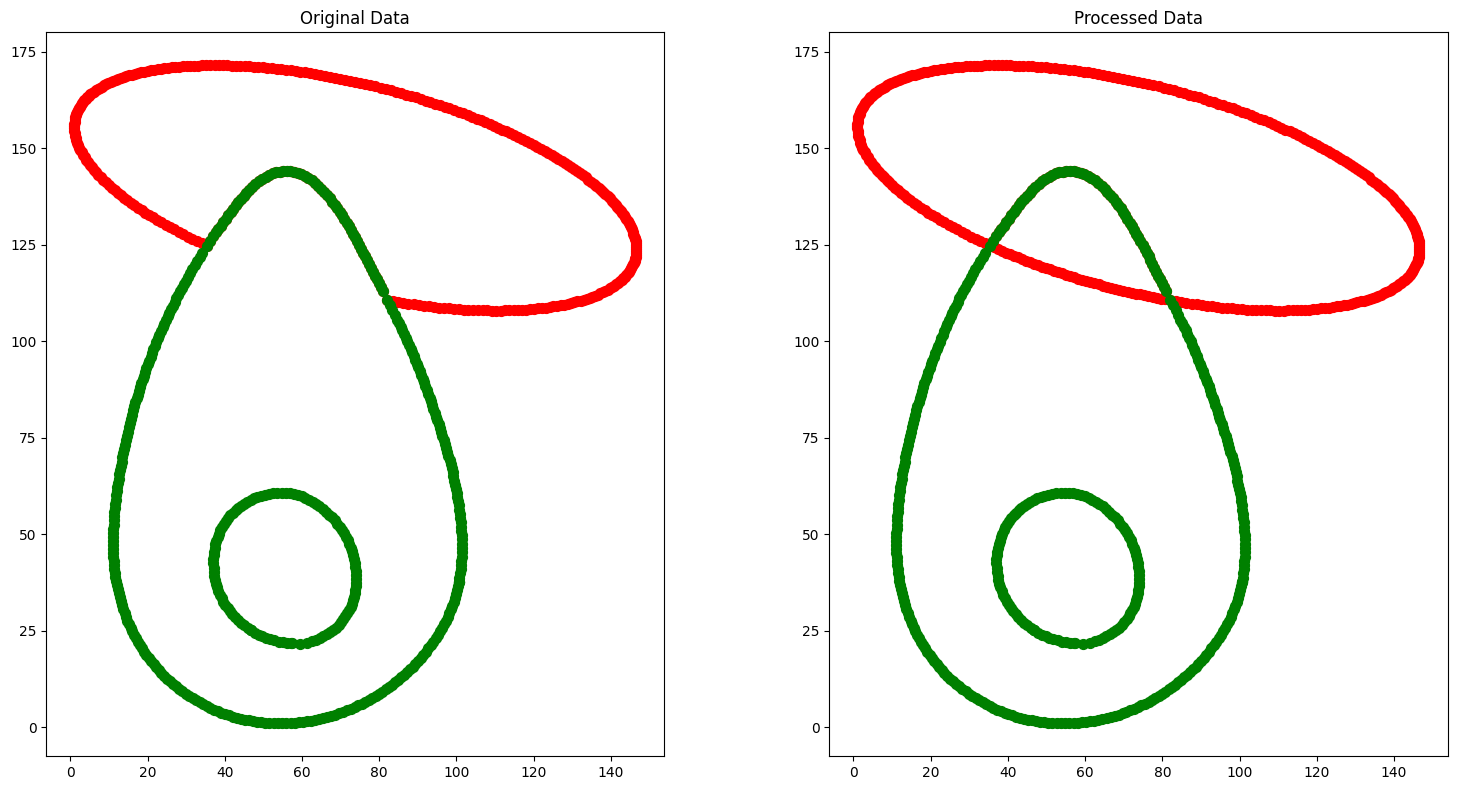

In [17]:
visualize_completed_curves('occlusion1.csv', 'interpolate')

In [18]:
complete_curves('occlusion2.csv', 'interpolate')

Total curves to process: 5
Now processing curve 0 ...
Now processing curve 1 ...
Now processing curve 2 ...
Now processing curve 3 ...
Now processing curve 4 ...
Processed curves have been saved to occlusion2_interpolate_output.csv


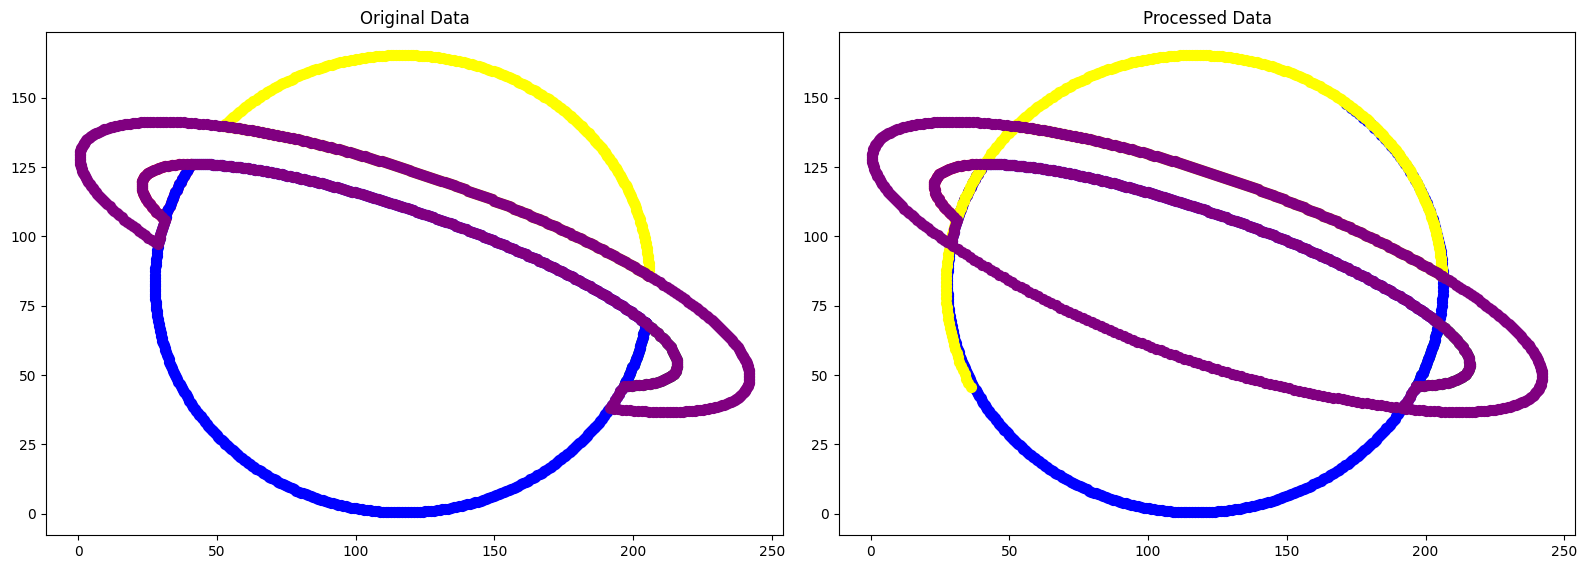

In [19]:
visualize_completed_curves('occlusion2.csv', 'interpolate')

## Curve Completion Approach 2: Solving Occlusion using MODEL FITTING

---



In [20]:
import random
from skimage.measure import EllipseModel, CircleModel
import scipy.optimize as opt
from tqdm import tqdm

In [21]:
def custom_ransac_ellipse(points, max_trials=1000, residual_threshold=2):
    
    points = np.array(points)  # Convert to NumPy array if not already
    best_model = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_trials):
        # Randomly select 5 indices
        sample_indices = random.sample(range(len(points)), 5)

        # Use these indices to get the corresponding points
        sample_points = points[sample_indices]

        # Fit an ellipse model to these points
        model = EllipseModel()
        if not model.estimate(sample_points):
            continue

        # Calculate the residuals (distances of points to the fitted ellipse)
        residuals = np.abs(model.residuals(points))

        # Determine inliers
        inliers = residuals < residual_threshold
        num_inliers = np.sum(inliers)

        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_model = model
            best_inliers = inliers
            max_inliers = num_inliers

    return best_model, best_inliers

In [22]:
def custom_ransac_circle(points, max_trials=1000, residual_threshold=2):
    
    points = np.array(points)
    best_model = None
    best_inliers = []
    max_inliers = 0

    for _ in range(max_trials):
        # Randomly select 3 indices
        sample_indices = random.sample(range(len(points)), 3)
        sample_points = points[sample_indices]

        # Fit a circle model to these points
        model = CircleModel()
        if not model.estimate(sample_points):
            continue

        # Calculate the residuals (distances of points to the fitted circle)
        residuals = np.abs(model.residuals(points))

        # Determine inliers
        inliers = residuals < residual_threshold
        num_inliers = np.sum(inliers)

        # Update the best model if it has more inliers
        if num_inliers > max_inliers:
            best_model = model
            best_inliers = inliers
            max_inliers = num_inliers

    return best_model, best_inliers

In [23]:
# Define a cost function to minimize the geometric distance to the ellipse
def cost_function(params, points):
    xc, yc, a, b, theta = params
    total_distance = 0
    for (x, y) in points:
        x_rot = (x - xc) * np.cos(theta) + (y - yc) * np.sin(theta)
        y_rot = -(x - xc) * np.sin(theta) + (y - yc) * np.cos(theta)
        distance = (x_rot / a)**2 + (y_rot / b)**2 - 1
        total_distance += np.abs(distance)
    return total_distance

In [24]:
def get_ellipse_boundary_points(ellipse, count=100):

    (x0, y0), (a, b), theta = ellipse
    boundary_points = []

    for t in np.linspace(0, 2 * np.pi, count):
        x = a / 2 * np.cos(t)
        y = b / 2 * np.sin(t)
        x_rot = x * np.cos(np.radians(theta)) - y * np.sin(np.radians(theta))
        y_rot = x * np.sin(np.radians(theta)) + y * np.cos(np.radians(theta))
        boundary_points.append([x_rot + x0, y_rot + y0])

    return np.array(boundary_points)

In [25]:
def get_circle_boundary_points(circle, count=100):

    (x0, y0), radius = circle
    boundary_points = []

    for t in np.linspace(0, 2 * np.pi, count):
        x = radius * np.cos(t)
        y = radius * np.sin(t)
        boundary_points.append([x + x0, y + y0])

    return np.array(boundary_points)

In [26]:
def process_curves_and_save_to_csv(input_csv_file, closed_curves, output_csv_file):

    def calculate_residuals(points, model_boundary_points):
        """ Calculate the sum of residuals between points and model boundary points. """
        return np.sum([np.min([np.linalg.norm(p - mbp) for mbp in model_boundary_points]) for p in points])

    def fit_ellipse(remaining_points):
        """ Fit an ellipse to the remaining points using RANSAC. """
        model_ellipse, inliers = custom_ransac_ellipse(remaining_points)
        if model_ellipse is not None:
            xc, yc, a, b, theta = model_ellipse.params
            ellipse = ((xc, yc), (2 * a, 2 * b), np.degrees(theta))
            initial_guess = (ellipse[0][0], ellipse[0][1], ellipse[1][0] / 2, ellipse[1][1] / 2, np.radians(ellipse[2]))
            result = opt.minimize(cost_function, initial_guess, args=(remaining_points,), method='L-BFGS-B')
            xc, yc, a, b, theta = result.x
            refined_ellipse = ((xc, yc), (2 * a, 2 * b), np.degrees(theta))
            return get_ellipse_boundary_points(refined_ellipse, len(remaining_points))
        return None

    def fit_circle(remaining_points):
        """ Fit a circle to the remaining points using RANSAC. """
        model_circle, inliers = custom_ransac_circle(remaining_points)
        if model_circle is not None:
            xc, yc, r = model_circle.params
            circle = ((xc, yc), r)
            return get_circle_boundary_points(circle, len(remaining_points))
        return None

    print(f'Total curves to process: {len(closed_curves)}')

    with open(output_csv_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        i = 0
        for idx, curve in tqdm(enumerate(closed_curves), total=len(closed_curves), desc=f'Processing curves'):
            i += 1
            points = extract_all_points_from_curve(curve, input_csv_file)

            # Remove points that coincide with any other curve
            remaining_points = points
            for j, other_curve in enumerate(closed_curves):
                if j != idx:
                    remaining_points = remove_coincident_points(remaining_points, extract_all_points_from_curve(other_curve, input_csv_file), tolerance=1)

            if len(remaining_points) < 5:
                print(f"\nSkipping curve {idx} - Not enough remaining points to process after removing coincident points.")
                continue

            # Fit ellipse with progress bar
            with tqdm(total=1, desc=f'Fitting Ellipse to Curve {idx}', position=1, leave=False) as pbar:
                ellipse_boundary = fit_ellipse(remaining_points)
                pbar.update(1)

            # Fit circle with progress bar
            with tqdm(total=1, desc=f'Fitting Circle to Curve {idx}', position=1, leave=False) as pbar:
                circle_boundary = fit_circle(remaining_points)
                pbar.update(1)

            # Calculate residuals for both models
            ellipse_residuals = calculate_residuals(remaining_points, ellipse_boundary) if ellipse_boundary is not None else float('inf')
            circle_residuals = calculate_residuals(remaining_points, circle_boundary) if circle_boundary is not None else float('inf')

            # Determine the better model
            if ellipse_residuals < circle_residuals:
                print("\nEllipse provides a better fit.\n")
                best_boundary = ellipse_boundary
                best_model_type = "ellipse"
            else:
                print("\nCircle provides a better fit.\n")
                best_boundary = circle_boundary
                best_model_type = "circle"

            if best_boundary is not None:
                # Check if the remaining points coincide with the best boundary
                remaining_points_after_check = remove_coincident_points(remaining_points, best_boundary, tolerance=1.5)
                model_coincides = len(remaining_points_after_check) == 0

                if model_coincides:
                    # Store the boundary points of the best-fitting model in the CSV file
                    for point in best_boundary:
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])

                    # Also write the original points after removing those coinciding with the best boundary
                    for point in remove_coincident_points(points, best_boundary, tolerance=1.5):
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])
                else:
                    print(f"The best model ({best_model_type}) does not fully coincide with the points.")
                    # Store the original points in the CSV file
                    for point in points:
                        writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])
            else:
                print("\nNo valid model was found.")
                # Store the original points in the CSV file
                for point in points:
                    writer.writerow([curve[0][0], curve[0][1], point[0], point[1]])

    print(f"\nProcessed curves saved to {output_csv_file}")

In [27]:
complete_curves('occlusion1.csv', 'model')

Total curves to process: 3


Fitting Ellipse to Curve 0: 100%|██████████| 1/1 [01:21<00:00, 81.48s/it]
                                                                         
Fitting Circle to Curve 0: 100%|██████████| 1/1 [00:00<00:00,  3.52it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 1: 100%|██████████| 1/1 [00:51<00:00, 51.77s/it]
                                                                         
Fitting Circle to Curve 1: 100%|██████████| 1/1 [00:00<00:00,  3.70it/s]
                                                                        


Ellipse provides a better fit.



Processing curves:  67%|██████▋   | 2/3 [02:17<01:06, 66.24s/it]

The best model (ellipse) does not fully coincide with the points.



Fitting Ellipse to Curve 2: 100%|██████████| 1/1 [00:23<00:00, 23.03s/it]
                                                                         
Processing curves: 100%|██████████| 3/3 [02:42<00:00, 54.02s/it]


Ellipse provides a better fit.


Processed curves saved to occlusion1_model_output.csv


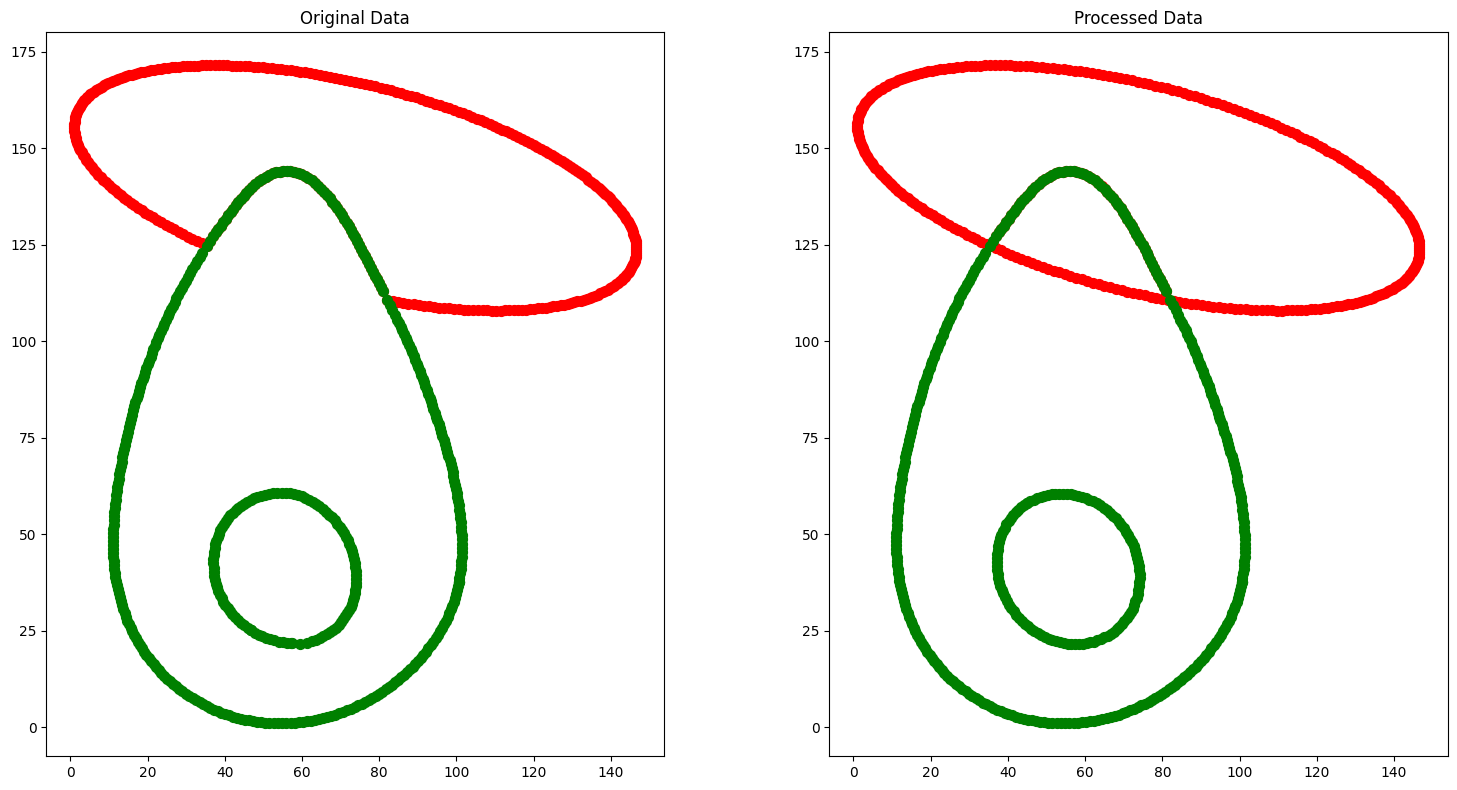

In [28]:
visualize_completed_curves('occlusion1.csv', 'model')

In [29]:
complete_curves('occlusion2.csv', 'model')

Total curves to process: 5


Processing curves:  20%|██        | 1/5 [00:00<00:01,  2.56it/s]


Skipping curve 0 - Not enough remaining points to process after removing coincident points.


Processing curves:  40%|████      | 2/5 [00:00<00:01,  2.43it/s]


Skipping curve 1 - Not enough remaining points to process after removing coincident points.



Fitting Ellipse to Curve 2: 100%|██████████| 1/1 [00:58<00:00, 58.05s/it]
                                                                         
Fitting Circle to Curve 2: 100%|██████████| 1/1 [00:00<00:00,  3.43it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 3: 100%|██████████| 1/1 [00:51<00:00, 51.64s/it]
                                                                         
Fitting Circle to Curve 3: 100%|██████████| 1/1 [00:00<00:00,  4.00it/s]
                                                                        


Ellipse provides a better fit.



Fitting Ellipse to Curve 4: 100%|██████████| 1/1 [00:54<00:00, 54.89s/it]
                                                                         
Fitting Circle to Curve 4: 100%|██████████| 1/1 [00:00<00:00,  4.06it/s]
                                                                        


Ellipse provides a better fit.



Processing curves: 100%|██████████| 5/5 [02:57<00:00, 35.46s/it]


Processed curves saved to occlusion2_model_output.csv


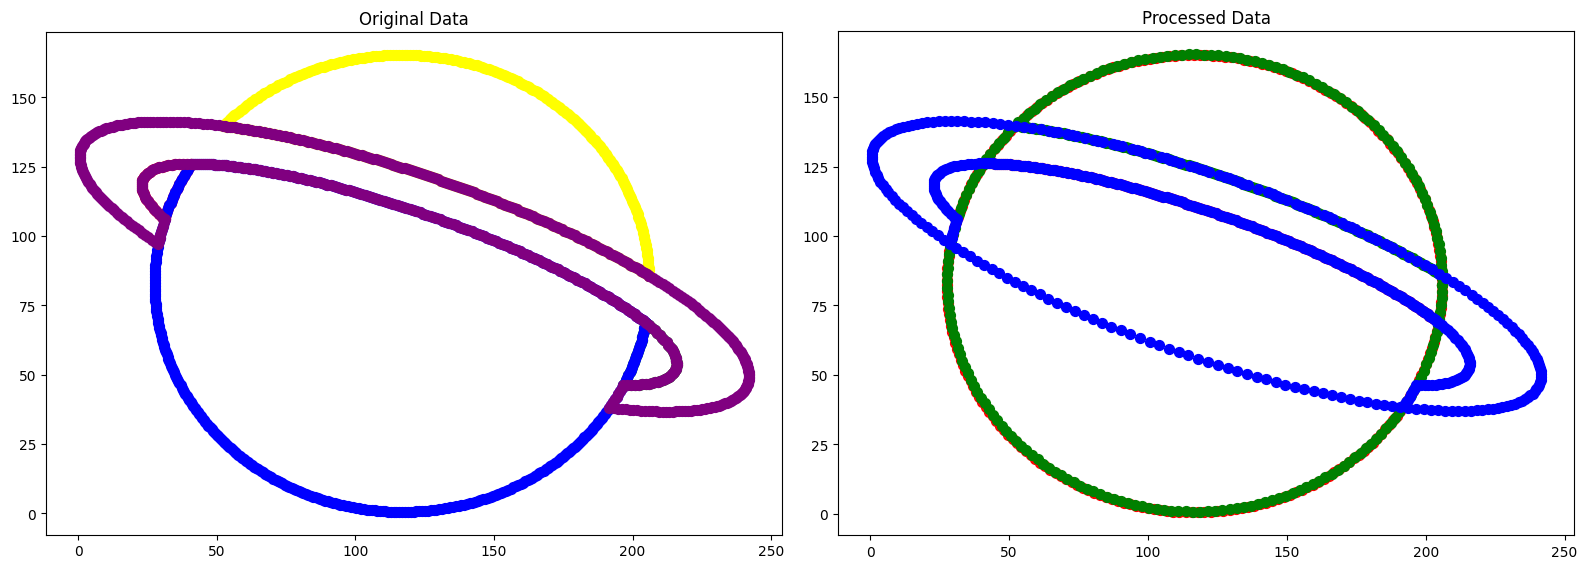

In [30]:
visualize_completed_curves('occlusion2.csv', 'model')